In [1]:
import pandas as pd, numpy as np, cPickle as pkl 
import sys, os 
sys.path.append('./dataprep/') 
from QueryFunctions import * 
from queryrunner_client import Client 

qr = Client(user_email='will.zou@uber.com') 


In [2]:
cities = '4, 5, 10, 12, 14, 15, 21, 24, 26, 30, 35, 40, 45, 48, 50, 88, 93, 139, 142' 
yesterday_ds = '2019-10-28' 

predFrame = qr.execute('presto-secure', subs_upsell_data_short(yesterday_ds, cities)) 
predFrame = pd.DataFrame(predFrame.load_data()) 

len(predFrame)
sum(predFrame['cohort'] == 'control')


11/02/2019 01:05:17 AM  [Polling] 77155609-ad60-4f9a-8840-477e2b39979f 
11/02/2019 01:05:17 AM  [Status] pending validation 
11/02/2019 01:05:18 AM  [Status] pending execution 
11/02/2019 01:05:22 AM  [Status] in execution 
11/02/2019 01:05:22 AM  [External ID] 5fa4a699-38dd-4c63-b8e3-2f5acb21f409 
11/02/2019 01:05:33 AM  [Details] {u'queryErrorMessage': u'', u'startTimestamp': u'', u'errorMessage': u'', u'isSuccess': True, u'queryState': u'RUNNING', u'aggregatePercentage': 0, u'queryErrorCode': 0, u'endTimestamp': u''} 
11/02/2019 01:06:42 AM  [Status] finished success 
11/02/2019 01:06:42 AM  [Query Success] finished success 


132027

In [3]:

### preprocess the data 
### -- sample treatment to match control cohort 
### -- eliminate nulls, standard normalization 

D = predFrame 
D = D.sample(frac=1.0) 

feature_list = [ 
        'trip_complete_84d',
        'trip_complete_per_days_active_84d',
        'promo_used_84d',
        'trip_x_prc_84d',
        'trip_pool_prc_84d',
        'trip_pool_per_x_84d',
        'session_per_days_active_84d',
        'session_request_prc_84d',
        'session_background_pre_request_prc_84d',
        'has_session_request_84d',
        'duration_session_outside_total_prc_84d',
        'has_session_without_request_84d',
        'payment_cash_trip_prc_84d',
        'surge_trip_prc_84d',
        'ufp_trip_not_honored_prc_84d',
        'ufp_trip_total_prc_84d',
        'trip_promo_prc_84d',
        'trip_complete_prc_84d',
        'trip_rider_cancelled_prc_84d',
        'trip_driver_cancelled_prc_84d',
        'request_to_trip_prc_84d',
        'days_session_request_prc_84d',
        'trips_lifetime',
        'trip_complete_win7d_potential_84d',
        'days_since_trip_first_lifetime',
        'trip_complete_win28d_potential_84d',
        'fare_total_win7d_potential_84d',
        'trip_total_total_84d',
        'fare_total_win28d_potential_84d',
        'days_since_last_soft_churn_lifetime',
        'days_active_84d',
        'days_since_last_hard_churn_lifetime', 
        'session_lt_1m_prc_84d', 
        'fare_max_p50_84d', 
        'uber_preferred_score' 
] 

label_list = [ 
    'buy_pass_15d', 
    'total_trip_dropoff' 
] 

for l in feature_list: 
    print('number of nans: ' + str(sum(D[l] == '\N'))) 
    D[l] = pd.to_numeric(D[l], errors='coerce') 
    D[l] = D[l] - D[l].mean() 
    D[l] = D[l] / D[l].std() 
    D[l][pd.isnull(D[l])] = 0.0 ## at zero mean due to standard normalization 

for l in label_list: 
    D[l] = pd.to_numeric(D[l], errors='coerce') 
    D[l][pd.isnull(D[l])] = 0.0 ## at zero mean due to standard normalization 

### -- compute simple statistics 
### compute cpit 
treated_entries = D[D['cohort'] == 'treatment'] 
untreated_entries = D[D['cohort'] == 'control'] 

rpu_treated = float(treated_entries[label_list[0]].sum()) / len(treated_entries) 
nipu_treated = float(treated_entries[label_list[1]].sum()) / len(treated_entries) 

rpu_untreated = float(untreated_entries[label_list[0]].sum()) / len(untreated_entries) 
nipu_untreated = float(untreated_entries[label_list[1]].sum()) / len(untreated_entries) 

cpit = (nipu_treated - nipu_untreated) / (rpu_treated - rpu_untreated) 

print('rpu_treated : ' + str(rpu_treated)) 
print('nipu_treated : ' + str(nipu_treated)) 
print('rpu_untreated : ' + str(rpu_untreated)) 
print('nipu_untreated : ' + str(nipu_untreated)) 
print('cpit : ' + str(cpit)) 

### split the data into 3/1/1 train/val/test 
len_tr = len(D) / 5 * 3 
len_va = len(D) / 5 * 2 

nX = D[feature_list].as_matrix() 
w = D['cohort'].apply(lambda x: 1.0 if x == 'treatment' else 0.0) 
w = w.as_matrix() 
values = D[label_list[0]] 
values = values.as_matrix() 
negcost = D[label_list[1]] 
negcost = negcost.as_matrix() * -1.0 

## split train/val/test sets 

nX_tr = nX[0:len_tr, :] 
nX_va = nX[len_tr:len_tr + len_va, :] 
nX_te = nX[len_tr + len_va:, :] 

w_tr = w[0:len_tr]
w_va = w[len_tr:len_tr + len_va] 
w_te = w[len_tr + len_va:] 

values_tr = values[0:len_tr] 
values_va = values[len_tr:len_tr + len_va] 
values_te = values[len_tr + len_va:] 

negcost_tr = negcost[0:len_tr] 

negcost_va = negcost[len_tr:len_tr + len_va] 

negcost_te = negcost[len_tr + len_va:] 

## saving data using cPickel and naming the dictionaries 
saveD = {'nX_tr':nX_tr, 
         'w_tr':w_tr, 
         'values_tr':values_tr, 
         'nX_va':nX_va, 
         'w_va':w_va, 
         'values_va':values_va, 
         'nX_te':nX_te, 
         'w_te':w_te, 
         'values_te':values_te, 
         'feature_list':feature_list, 
         #'avg_ni_usd_tr':avg_ni_usd_tr, 
         'negcost_tr': negcost_tr, 
         #'avg_ni_usd_va':avg_ni_usd_va, 
         'negcost_va': negcost_va, 
         #'avg_ni_usd_te':avg_ni_usd_te, 
         'negcost_te': negcost_te 
         } 
pkl.dump(saveD, open('data/subs_upsell_ma_training_data_v2', 'w')) 


/home/udocker/phoenix-worker/environments/python2/local/lib/python2.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


number of nans: 0


/home/udocker/phoenix-worker/environments/python2/lib/python2.7/site-packages/ipykernel_launcher.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0
number of nans: 0


/home/udocker/phoenix-worker/environments/python2/lib/python2.7/site-packages/ipykernel_launcher.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


rpu_treated : 0.0474821185474
nipu_treated : 0.0598528462527
rpu_untreated : 0.0336067622532
nipu_untreated : 0.050762344066
cpit : 0.655154505146


/home/udocker/phoenix-worker/environments/python2/lib/python2.7/site-packages/ipykernel_launcher.py:87: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/udocker/phoenix-worker/environments/python2/lib/python2.7/site-packages/ipykernel_launcher.py:89: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/udocker/phoenix-worker/environments/python2/lib/python2.7/site-packages/ipykernel_launcher.py:91: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
/home/udocker/phoenix-worker/environments/python2/lib/python2.7/site-packages/ipykernel_launcher.py:93: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


In [4]:
import numpy as np, tensorflow as tf, pandas as pd, pickle as pkl 
from ModelDefinitions import * 

#Dd = pkl.load(open('data/LCLatamAug2018TrainingData', 'r')) 
#Dd = pkl.load(open('data/drm_train_data_from_hscls547_allcohorts11weeks_sav__seq_start0.pkl', 'r')) 
Dd = pkl.load(open('data/subs_upsell_ma_training_data_v2', 'r')) 

p_quantile = 0.25 ## percentage of users to target 
num_optimize_iterations = 85 

### parsing data from saved pickle 
#D = Dd['nX_tr']; w = Dd['w_tr']; ni = Dd['n9d_ni_usd_tr']; o = Dd['values_tr']; c = -1.0 * ni 
#Dv = Dd['nX_va']; wv = Dd['w_va']; niv = Dd['n9d_ni_usd_va']; ov = Dd['values_va']; cv = -1.0 * niv 

D = Dd['nX_tr']; w = Dd['w_tr']; ni = Dd['negcost_tr']; o = Dd['values_tr']; c = -1.0 * ni 
Dv = Dd['nX_va']; wv = Dd['w_va']; niv = Dd['negcost_va']; ov = Dd['values_va']; cv = -1.0 * niv 

if type(c) != type(o): 
    c = c.as_matrix()
if type(cv) != type(ov):
    cv = cv.as_matrix() 

if type(ni) != type(o): 
    ni = ni.as_matrix()
if type(cv) != type(ov):
    niv = niv.as_matrix() 

if w.shape[-1] == 1: 
    w = np.reshape(w, (len(w), )) 
if wv.shape[-1] == 1: 
    wv = np.reshape(wv, (len(wv), )) 
if o.shape[-1] == 1: 
    o = np.reshape(o, (len(o), )) 
if c.shape[-1] == 1: 
    c = np.reshape(c, (len(c), ))  
if ov.shape[-1] == 1: 
    ov = np.reshape(ov, (len(ov), )) 
if cv.shape[-1] == 1: 
    cv = np.reshape(cv, (len(cv), )) 

### - todo: put this in DataProcFunctions 
# [todo: start] 
filter = ~ np.isnan(c) 
D = D[np.where(filter==True)[0], :] 
w = w[np.where(filter==True)[0]] 
c = c[np.where(filter==True)[0]] 
o = o[np.where(filter==True)[0]] 
filter = ~ np.isnan(cv) 
Dv = Dv[np.where(filter==True)[0], :] 
wv = wv[np.where(filter==True)[0]] 
cv = cv[np.where(filter==True)[0]] 
ov = ov[np.where(filter==True)[0]] 

ridx = np.random.permutation(len(D)) 
#ridx = np.arange(len(D))
#ridx = ridx[0:39000] 
D = D[ridx, :] 
w = w[ridx] 
ni = ni[ridx] 
o = o[ridx] 
c = c[ridx] 


D_tre = D[w > 0.5, :] 
D_unt = D[w < 0.5, :] 

Dv_tre = Dv[wv > 0.5, :] 
Dv_unt = Dv[wv < 0.5, :] 

o_tre = o[w > 0.5] 
o_unt = o[w < 0.5] 

ov_tre = ov[wv > 0.5] 
ov_unt = ov[wv < 0.5] 

c_tre = c[w > 0.5] 
c_unt = c[w < 0.5] 

cv_tre = cv[wv > 0.5] 
cv_unt = cv[wv < 0.5] 

print(np.average(c_tre)); print(np.average(c_unt)); print(np.average(o_tre)); print(np.average(o_unt)) 
# [todo: end] 

#obj, opt, dumh, dumhu = TopPRankingModel(D_tre, D_unt, o_tre, o_unt, c_tre, c_unt, p_quantile, 'train-first') 
obj, opt, dumh, dumhu, vtemp, vp_quantile = TunableTopPRankingModel(D_tre, D_unt, o_tre, o_unt, c_tre, c_unt, 'train-first') 

### session definitions and variable initialization 
sess = tf.Session() 
### initialize variables and run optimization 
init = tf.global_variables_initializer() 
sess.run(init) 
for step in range(num_optimize_iterations): 
    print('step : ' + str(step)) 
    _, objres = sess.run([opt, obj]) 
    print(objres) 

tempvalue = sess.run(vtemp)
p_quantilevalue = sess.run(vp_quantile)
print('temp:') 
print(tempvalue)
print('vp_quantile:')
print(p_quantilevalue) 

### evaluate CPIT metric on validation set 
#objv, dumo, dumh, dumhu = TopPRankingModel(Dv_tre, Dv_unt, ov_tre, ov_unt, cv_tre, cv_unt, p_quantile, 'eval') 
objv, dumo, dumh, dumhu, dvtemp, dvp_quantile = TunableTopPRankingModel(Dv_tre, Dv_unt, ov_tre, ov_unt, cv_tre, cv_unt, 'eval') 

print('validation CPIT:') 
print(sess.run(objv)) 

### run scoring on whole validation set 
with tf.variable_scope("toppranker") as scope: 
    h_tre = tf.contrib.layers.fully_connected(Dv, 1, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE, scope=scope) 
topprnkscore = sess.run(h_tre) 

### ---- train cpit ranking model for comparison --- 
objc, optc, dumh, dumu = DirectRankingModel(D_tre, D_unt, o_tre, o_unt, c_tre, c_unt, 'train-first-cpit') 

### initialize variables and run optimization 
init = tf.global_variables_initializer() 
sess.run(init) 
for step in range(num_optimize_iterations): 
    print('step : ' + str(step)) 
    _, objcres = sess.run([optc, objc]) 
    print(objcres) 

### run scoring on whole validation set 
with tf.variable_scope("cpitranker") as scope: 
    h_tre = tf.contrib.layers.fully_connected(Dv, 1, activation_fn=tf.nn.tanh, reuse=tf.AUTO_REUSE, scope=scope) 
cpitrnkscore = sess.run(h_tre) 

### ---- train hte model for comparison ---- 
### we could utimize the original HTE functions 
from LinearHTEModels import * 
lhmodels = LinearHTEModels() 
lambds = [0.0005, 0.05] 
rlearnerscores = [] 
rl_ridge_model_L_list = [] 
## set-up lagrangian rlearner 
for i in range(len(lambds)): 
    lambd = lambds[i] 
    rl_ridge_model_L = lhmodels.fit_rlearner_lagrangian(D, o, c, w, lambd) 
    rl_ridge_model_L_list.append(rl_ridge_model_L) 
    rlearnerscores.append(rl_ridge_model_L.predict(Dv)) 

from sklearn.ensemble import RandomForestRegressor 
subs_upsell_model = RandomForestRegressor(max_depth=3, random_state=0, n_estimators=100) 
print(' ++++++ fitting online upsell model .... +++++++ ') 
subs_upsell_model.fit(D, o) 
rf_upsell_model_scores = subs_upsell_model.predict(Dv) 

### ---- experimentation and plotting cost-curves ----- 
from experimentation import * 
exp = Experimentation() 
ranscore = np.random.rand(topprnkscore.shape[0], ) 
colors = ['b', 'c'] 
"""
plt.figure() 
exp.AUC_cpit_cost_curve_deciles_cohort(ranscore, ov, wv, niv, 'k' ) 
for i in range(len(lambds)): 
    exp.AUC_cpit_cost_curve_deciles_cohort(rlearnerscores[i], ov, wv, niv, colors[i] ) 
exp.AUC_cpit_cost_curve_deciles_cohort(topprnkscore, ov, wv, niv, 'r' ) 
exp.AUC_cpit_cost_curve_deciles_cohort(cpitrnkscore, ov, wv, niv, 'm' ) 
exp.AUC_cpit_cost_curve_deciles_cohort(cpitrnkscore, ov, wv, niv, 'g' ) 
plt.title('Cost Curves using targeting models') 

print('temp:') 
print(tempvalue)
print('vp_quantile:')
print(p_quantilevalue) 

leg_str = ['random'] 
for i in range(len(lambds)): 
    leg_str.append('hetero-treatment-ridge-reg (lamb=' +str(lambds[i])+ ',lang-rlearner)') 
leg_str.append('fqr ranking') 
leg_str.append('cpit ranking') 
plt.legend(leg_str) 
plt.show() 
"""

W1101 18:53:18.981856 139986817287936 deprecation_wrapper.py:119] From /mnt/cephfs/hadoop-compute/phoenix/will.zou/Michelangelo/hsclsma/ModelDefinitions.py:135: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.

W1101 18:53:18.983994 139986817287936 deprecation_wrapper.py:119] From /mnt/cephfs/hadoop-compute/phoenix/will.zou/Michelangelo/hsclsma/ModelDefinitions.py:135: The name tf.AUTO_REUSE is deprecated. Please use tf.compat.v1.AUTO_REUSE instead.

W1101 18:53:18.985690 139986817287936 deprecation_wrapper.py:119] From /mnt/cephfs/hadoop-compute/phoenix/will.zou/Michelangelo/hsclsma/ModelDefinitions.py:136: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



0.05992518151527544
0.051200867854079415
0.04782416315256669
0.033263534991674656


W1101 18:53:19.712173 139986817287936 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1101 18:53:20.305602 139986817287936 deprecation_wrapper.py:119] From /mnt/cephfs/hadoop-compute/phoenix/will.zou/Michelangelo/hsclsma/ModelDefinitions.py:155: The name tf.ceil is deprecated. Please use tf.math.ceil instead.

W1101 18:53:20.375473 139986817287936 deprecation_wrapper.py:119] From /mnt/cephfs/hadoop-compute/phoenix/will.zou/Michelangelo/hsclsma/ModelDefinitions.py:187: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.



step : 0
0.5225662301144329
step : 1
0.5157529008064712
step : 2
0.5105549452724891
step : 3
0.5065754602037732
step : 4
0.502355711490003
step : 5
0.4974107534303973
step : 6
0.4926069377973037
step : 7
0.48818152286661354
step : 8
0.4834930586823411
step : 9
0.4780153881847226
step : 10
0.4731157666302853
step : 11
0.46774497868053694
step : 12
0.46235027968519915
step : 13
0.459208216764296
step : 14
0.4558291377674376
step : 15
0.45265609891458863
step : 16
0.44975500212358543
step : 17
0.4463310339739879
step : 18
0.4423645511984434
step : 19
0.43860537915708203
step : 20
0.4347490104457233
step : 21
0.43077371160040834
step : 22
0.4278417796329548
step : 23
0.4260391253937265
step : 24
0.4243620476298042
step : 25
0.4223815644205654
step : 26
0.4205916176720346
step : 27
0.4185551707220607
step : 28
0.415829046232841
step : 29
0.41215957974576967
step : 30
0.4086102542191116
step : 31
0.40575694712129895
step : 32
0.4032113501096143
step : 33
0.4007928025546519
step : 34
0.398495

"\nplt.figure() \nexp.AUC_cpit_cost_curve_deciles_cohort(ranscore, ov, wv, niv, 'k' ) \nfor i in range(len(lambds)): \n    exp.AUC_cpit_cost_curve_deciles_cohort(rlearnerscores[i], ov, wv, niv, colors[i] ) \nexp.AUC_cpit_cost_curve_deciles_cohort(topprnkscore, ov, wv, niv, 'r' ) \nexp.AUC_cpit_cost_curve_deciles_cohort(cpitrnkscore, ov, wv, niv, 'm' ) \nexp.AUC_cpit_cost_curve_deciles_cohort(cpitrnkscore, ov, wv, niv, 'g' ) \nplt.title('Cost Curves using targeting models') \n\nprint('temp:') \nprint(tempvalue)\nprint('vp_quantile:')\nprint(p_quantilevalue) \n\nleg_str = ['random'] \nfor i in range(len(lambds)): \n    leg_str.append('hetero-treatment-ridge-reg (lamb=' +str(lambds[i])+ ',lang-rlearner)') \nleg_str.append('fqr ranking') \nleg_str.append('cpit ranking') \nplt.legend(leg_str) \nplt.show() \n"

rpu_control: 0.03412257587533886
nipu_control: -0.05010331557695589
rpu_ft: 0.04696930862745689
nipu_ft: -0.059744397706313665
---------------------------->>>>>>
perc - target: 0.10
treated_target_rpu: 0.05
treated_target_nipu: -0.06
nontreated_target_rpu: 0.04
nontreated_target_nipu: -0.05
treated_nontarget_rpu: 0.05
treated_nontarget_nipu: -0.06
nontreated_nontarget_rpu: 0.03
nontreated_nontarget_nipu: -0.05
--- with 9.999920550426644% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 0.7678381806383101
--> in non-targeted users: 
cpit = 0.7485614201205911
rpu_control: 0.03
nipu_control: -0.05
rpu_ft: 0.05
nipu_ft: -0.06
rpu_cohort: 0.04
nipu_cohort: -0.05
lift targeted cohort vs control: 0.03
lift random vs control: 0.38
cpit cohort vs control: 0.77
lift targeted-treated vs control: 0.37
cpit cohort: 0.769158
---------------------------->>>>>>
perc - target: 0.20
treated_target_rpu: 0.05
treated_target_nipu: -0.06
nontreated_

---------------------------->>>>>>
perc - target: 0.20
treated_target_rpu: 0.09
treated_target_nipu: -0.07
nontreated_target_rpu: 0.05
nontreated_target_nipu: -0.04
treated_nontarget_rpu: 0.04
treated_nontarget_nipu: -0.06
nontreated_nontarget_rpu: 0.03
nontreated_nontarget_nipu: -0.05
--- with 19.99984110085329% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 0.6715482745183651
--> in non-targeted users: 
cpit = 0.6436289828832819
rpu_control: 0.03
nipu_control: -0.05
rpu_ft: 0.05
nipu_ft: -0.06
rpu_cohort: 0.04
nipu_cohort: -0.06
lift targeted cohort vs control: 0.20
lift random vs control: 0.38
cpit cohort vs control: 0.81
lift targeted-treated vs control: 1.57
cpit cohort: 0.807547
---------------------------->>>>>>
perc - target: 0.30
treated_target_rpu: 0.08
treated_target_nipu: -0.06
nontreated_target_rpu: 0.05
nontreated_target_nipu: -0.04
treated_nontarget_rpu: 0.04
treated_nontarget_nipu: -0.06
nontreated_nontarget_r

---------------------------->>>>>>
perc - target: 0.30
treated_target_rpu: 0.07
treated_target_nipu: -0.06
nontreated_target_rpu: 0.05
nontreated_target_nipu: -0.04
treated_nontarget_rpu: 0.04
treated_nontarget_nipu: -0.06
nontreated_nontarget_rpu: 0.03
nontreated_nontarget_nipu: -0.05
--- with 29.999761651279933% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 0.5849541519642889
--> in non-targeted users: 
cpit = 0.7649244358689778
rpu_control: 0.03
nipu_control: -0.05
rpu_ft: 0.05
nipu_ft: -0.06
rpu_cohort: 0.04
nipu_cohort: -0.06
lift targeted cohort vs control: 0.23
lift random vs control: 0.38
cpit cohort vs control: 0.70
lift targeted-treated vs control: 1.19
cpit cohort: 0.698802
---------------------------->>>>>>
perc - target: 0.40
treated_target_rpu: 0.07
treated_target_nipu: -0.06
nontreated_target_rpu: 0.04
nontreated_target_nipu: -0.05
treated_nontarget_rpu: 0.03
treated_nontarget_nipu: -0.06
nontreated_nontarget_

---------------------------->>>>>>
perc - target: 0.40
treated_target_rpu: 0.05
treated_target_nipu: -0.04
nontreated_target_rpu: 0.04
nontreated_target_nipu: -0.04
treated_nontarget_rpu: 0.04
treated_nontarget_nipu: -0.07
nontreated_nontarget_rpu: 0.03
nontreated_nontarget_nipu: -0.06
--- with 39.99968220170658% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 0.38646538095132027
--> in non-targeted users: 
cpit = 1.1718655969658374
rpu_control: 0.03
nipu_control: -0.05
rpu_ft: 0.05
nipu_ft: -0.06
rpu_cohort: 0.04
nipu_cohort: -0.05
lift targeted cohort vs control: 0.17
lift random vs control: 0.38
cpit cohort vs control: 0.28
lift targeted-treated vs control: 0.52
cpit cohort: 0.277596
---------------------------->>>>>>
perc - target: 0.50
treated_target_rpu: 0.05
treated_target_nipu: -0.05
nontreated_target_rpu: 0.04
nontreated_target_nipu: -0.04
treated_nontarget_rpu: 0.04
treated_nontarget_nipu: -0.07
nontreated_nontarget_

---------------------------->>>>>>
perc - target: 0.50
treated_target_rpu: 0.04
treated_target_nipu: -0.04
nontreated_target_rpu: 0.03
nontreated_target_nipu: -0.04
treated_nontarget_rpu: 0.05
treated_nontarget_nipu: -0.08
nontreated_nontarget_rpu: 0.04
nontreated_nontarget_nipu: -0.05
--- with 49.99960275213322% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 0.000254807371786159
--> in non-targeted users: 
cpit = 1.7402794345279793
rpu_control: 0.03
nipu_control: -0.05
rpu_ft: 0.05
nipu_ft: -0.06
rpu_cohort: 0.04
nipu_cohort: -0.05
lift targeted cohort vs control: 0.19
lift random vs control: 0.38
cpit cohort vs control: -0.11
lift targeted-treated vs control: 0.30
cpit cohort: -0.113564
---------------------------->>>>>>
perc - target: 0.60
treated_target_rpu: 0.04
treated_target_nipu: -0.05
nontreated_target_rpu: 0.03
nontreated_target_nipu: -0.06
treated_nontarget_rpu: 0.05
treated_nontarget_nipu: -0.07
nontreated_nontarg

---------------------------->>>>>>
perc - target: 0.60
treated_target_rpu: 0.06
treated_target_nipu: -0.07
nontreated_target_rpu: 0.04
nontreated_target_nipu: -0.06
treated_nontarget_rpu: 0.03
treated_nontarget_nipu: -0.04
nontreated_nontarget_rpu: 0.02
nontreated_nontarget_nipu: -0.04
--- with 59.999523302559865% targeting, print cpits to treat users and create incrementality in users ---
--> in targeted users: 
cpit = 0.787448032408481
--> in non-targeted users: 
cpit = 0.5890443421805208
rpu_control: 0.03
nipu_control: -0.05
rpu_ft: 0.05
nipu_ft: -0.06
rpu_cohort: 0.04
nipu_cohort: -0.06
lift targeted cohort vs control: 0.31
lift random vs control: 0.38
cpit cohort vs control: 0.79
lift targeted-treated vs control: 0.73
cpit cohort: 0.785649
---------------------------->>>>>>
perc - target: 0.70
treated_target_rpu: 0.05
treated_target_nipu: -0.07
nontreated_target_rpu: 0.04
nontreated_target_nipu: -0.05
treated_nontarget_rpu: 0.03
treated_nontarget_nipu: -0.04
nontreated_nontarget_r

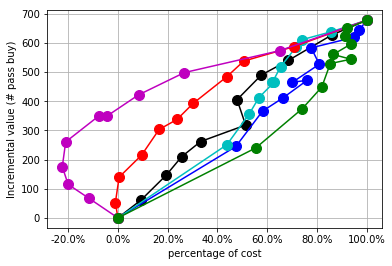

In [10]:
plt.figure() 
exp.AUC_cpit_cost_curve_deciles_cohort(ranscore, ov, wv, niv, 'k' ) 
for i in range(len(lambds)): 
    exp.AUC_cpit_cost_curve_deciles_cohort(rlearnerscores[i], ov, wv, niv, colors[i] ) 
exp.AUC_cpit_cost_curve_deciles_cohort(topprnkscore, ov, wv, niv, 'r' ) 
exp.AUC_cpit_cost_curve_deciles_cohort(cpitrnkscore, ov, wv, niv, 'm' ) 
exp.AUC_cpit_cost_curve_deciles_cohort(rf_upsell_model_scores, ov, wv, niv, 'g' ) 
plt.show() 


In [ ]:
print(niv[0:100])